In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 cd "/content/drive/MyDrive/CV LAB"

/content/drive/MyDrive/CV LAB


In [ ]:
import tensorflow as tf
from google.colab.patches import cv2_imshow
import dlib
import numpy as np
import preprocess
import os
import cv2
import numpy
#import argparse
#from datetime import datetime
import pandas

In [ ]:
import keras
from keras.constraints import MaxNorm
from keras.initializers import variance_scaling
from keras.models import Model
from keras.regularizers import  l2,l1
from keras.layers.convolutional import Conv2D
from keras.layers import Dense,Input
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten,Activation,concatenate,BatchNormalization,Dropout
from keras.activations import relu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Loading The Adience Benchmark Dataset

In [ ]:
#load data
data = pd.read_csv("/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv("/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt",sep = "\t")
data2 = pd.read_csv("/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt",sep = "\t")
data3 = pd.read_csv("/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt",sep = "\t")
data4 = pd.read_csv("/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt",sep = "\t")

In [ ]:
#total_data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)
total_data=data
print(data.shape)
print(total_data.shape)

(4484, 12)
(4484, 12)


In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             4484 non-null   object
 1   original_image      4484 non-null   object
 2   face_id             4484 non-null   int64 
 3   age                 4484 non-null   object
 4   gender              4431 non-null   object
 5   x                   4484 non-null   int64 
 6   y                   4484 non-null   int64 
 7   dx                  4484 non-null   int64 
 8   dy                  4484 non-null   int64 
 9   tilt_ang            4484 non-null   int64 
 10  fiducial_yaw_angle  4484 non-null   int64 
 11  fiducial_score      4484 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 420.5+ KB


In [ ]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [ ]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     4484 non-null   object
 1   gender  4431 non-null   object
 2   x       4484 non-null   int64 
 3   y       4484 non-null   int64 
 4   dx      4484 non-null   int64 
 5   dy      4484 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 210.3+ KB


In [ ]:
img_path = []
for row in total_data.iterrows():
    path = "/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [ ]:
df.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
1,"(25, 32)",m,301,105,640,641,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
2,"(25, 32)",f,2395,876,771,771,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
3,"(25, 32)",m,752,1255,484,485,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
4,"(25, 32)",m,175,80,769,768,/content/drive/MyDrive/CV LAB/AdienceBenchmark...


In [ ]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), 
               ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'),
               ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'),
               ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


25-32    1646
0-2       973
38-43     583
4-6       494
48-53     226
8-13      216
15-20     153
60+       141
Name: age, dtype: int64

In [ ]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 0 to 4481
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       3995 non-null   object
 1   gender    3995 non-null   object
 2   x         3995 non-null   int64 
 3   y         3995 non-null   int64 
 4   dx        3995 non-null   int64 
 5   dy        3995 non-null   int64 
 6   img_path  3995 non-null   object
dtypes: int64(4), object(3)
memory usage: 249.7+ KB


In [ ]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
1,4,1,301,105,640,641,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
2,4,0,2395,876,771,771,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
3,4,1,752,1255,484,485,/content/drive/MyDrive/CV LAB/AdienceBenchmark...
4,4,1,175,80,769,768,/content/drive/MyDrive/CV LAB/AdienceBenchmark...


In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
X = unbiased_data[['img_path']]
y = unbiased_data[['age']]
# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(X_train.shape, x_val.shape, X_test.shape)

(2996, 1) (599, 1) (400, 1)


In [ ]:
"""X = unbiased_data[['img_path']]
y = unbiased_data[['age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))"""

"X = unbiased_data[['img_path']]\ny = unbiased_data[['age']]\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nprint('Train data shape {}'.format(X_train.shape))\nprint('Test data shape {}'.format(X_test.shape))"

In [ ]:
#X_train=X_train[:1000]
print(len(X_train))
#y_train=y_train[:1000]
print(len(y_train))
#X_test=X_test[:150]
print(len(X_test))
#y_test=y_test[:150]
print(len(y_test))
#x_val=x_val[:150]
print(len(x_val))
#y_val=y_val[:150]
print(len(y_val))

2996
2996
400
400
599
599


In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7])

# **Pre Processing** 

In [ ]:
hog_face_detector = dlib.get_frontal_face_detector()

dlib_facelandmark = dlib.shape_predictor("/content/drive/MyDrive/CV LAB/shape_predictor_68_face_landmarks.dat.bz2 (Unzipped Files)/shape_predictor_68_face_landmarks.dat")

In [ ]:
def find_biggest_face(dets):
    face = dlib.rectangle(0, 0, 0, 0)

    for k, d in enumerate(dets):
        if d.area() >= face.area():
            face = d

    return face

def Dlib(path):
  image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
 
  #print('Original Dimensions : ',img.shape)
  #dim = (250, 250) 
  #gray = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  #print('Resized Dimensions : ',gray.shape)

  #image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  dets =  hog_face_detector(image,1)

  if (len(dets) <= 0):
    print("face not found " + str(len(dets)))
    d = dlib.rectangle(0, 0, image.shape[1], image.shape[0])
  else:
    d = find_biggest_face(dets)

  shape = dlib_facelandmark(image, d)

  dets = hog_face_detector(image, 1)
  return shape,dets,image



def face_feature(shape,dets,image):
  # eyebrows
  coordinates = preprocess.shape_to_np(shape)
  angle = preprocess.get_angle(coordinates[21, 0], coordinates[21, 1], coordinates[22, 0], coordinates[22, 1])
  eyebrows_img, coords = preprocess.rotate_image_and_coordinates(image, coordinates, angle)
        
  #segment the eyebrows region
  coords = coords[17:27, 0:2]
  minX, maxX, minY, maxY = preprocess.find_min_max(coords)

  try:
    eyebrows_img = preprocess.crop_and_resize(eyebrows_img, minX, maxX, minY, maxY, 0.03, 228, 33)
  except:
    eyebrows_img = cv2.resize(image, (228, 33))
    #print("Eyebrows not found") # negative list 
  
  # EYE 
  angle = preprocess.get_angle(coordinates[39, 0], coordinates[39, 1], coordinates[42, 0], coordinates[42, 1])
  eyes_img, coords = preprocess.rotate_image_and_coordinates(image, coordinates, angle)
        
  #segment the eyes region
  coords = coords[36:48, 0:2]
  minX, maxX, minY, maxY = preprocess.find_min_max(coords)

  try:
    eyes_img = preprocess.crop_and_resize(eyes_img, minX, maxX, minY, maxY, 0.03, 202, 38)
  except:
    eyes_img = cv2.resize(image, (202, 38))
    #print("Eyes not found") # negative list


  # Nose
  angle = preprocess.get_angle(coordinates[32, 0], coordinates[32, 1], coordinates[34, 0], coordinates[34, 1])
  nose_img, coords = preprocess.rotate_image_and_coordinates(image, coordinates, angle)
        
        # segment the nose region
  coords = coords[27:36, 0:2]
  minX, maxX, minY, maxY = preprocess.find_min_max(coords)

  try:
    nose_img = preprocess.crop_and_resize(nose_img, minX, maxX, minY, maxY, 0.4, 103, 73)
  except:
    nose_img = cv2.resize(image, (103, 73))
    #print("Nose not found") # negative list
  

#### mouth
  angle = preprocess.get_angle(coordinates[48, 0], coordinates[48, 1], coordinates[54, 0], coordinates[54, 1])
  mouth_img, coords = preprocess.rotate_image_and_coordinates(image, coordinates, angle)
        
        # segment the mouth region
  coords = coords[48:68, 0:2]
  minX, maxX, minY, maxY = preprocess.find_min_max(coords)

  try:
    mouth_img = preprocess.crop_and_resize(mouth_img, minX, maxX, minY, maxY, 0.08, 114, 66)
  except:
    mouth_img = cv2.resize(image, (114, 66))
    #print("Mouth not found") # negative list
  
  
  return eyebrows_img,eyes_img,nose_img,mouth_img

## Face Landmarks detection

Original Dimensions :  (396, 396, 3)
Resized Dimensions :  (816, 816, 3)


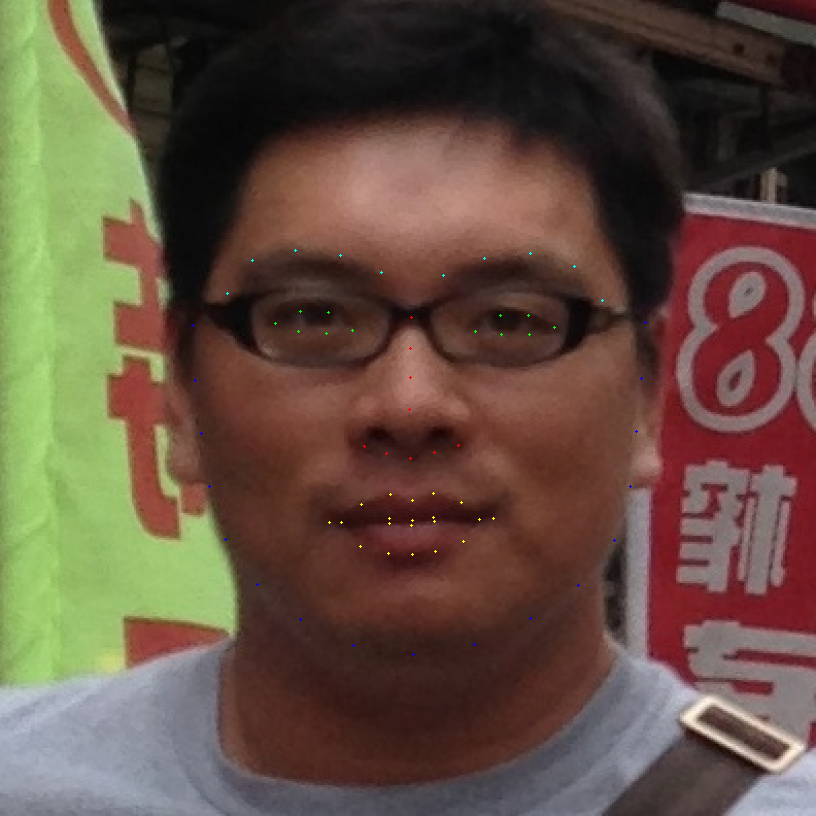

In [ ]:

def find_biggest_face(dets):
    face = dlib.rectangle(0, 0, 0, 0)

    for k, d in enumerate(dets):
        if d.area() >= face.area():
            face = d

    return face

hog_face_detector = dlib.get_frontal_face_detector()

dlib_facelandmark = dlib.shape_predictor("/content/drive/MyDrive/CV LAB/shape_predictor_68_face_landmarks.dat.bz2 (Unzipped Files)/shape_predictor_68_face_landmarks.dat")
img = cv2.imread('/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/AdienceBenchmarkGenderAndAgeClassification/faces/10001312@N04/coarse_tilt_aligned_face.619.8530902519_a7778febdb_o.jpg', cv2.IMREAD_UNCHANGED)
 
print('Original Dimensions : ',img.shape)
dim = (816, 816) 
# resize image
gray = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',gray.shape)

image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

dets =  hog_face_detector(gray,1)

if (len(dets) <= 0):
  print("face not found " + str(len(dets)))
  d = dlib.rectangle(0, 0, image.shape[1], image.shape[0])
else:
  d = find_biggest_face(dets)

shape = dlib_facelandmark(gray, d)

dets = hog_face_detector(gray, 1)

# select a color for each facial part

# 1-17 face contour
color = (255, 0, 0) # blue
for i in range(0, 17):
  cv2.circle(gray, (shape.part(i).x, shape.part(i).y), 1, color, -1)

# 18-27 eyebrows
color = (255, 255, 0) # cyan
for i in range(17, 27):
  cv2.circle(gray, (shape.part(i).x, shape.part(i).y), 1, color, -1)

# 28-36 nose
color = (0, 0, 255) # red
for i in range(27, 36):
  cv2.circle(gray, (shape.part(i).x, shape.part(i).y), 1, color, -1)

# 37-48 eyes
color = (0, 255, 0) # green
for i in range(36, 48):
  cv2.circle(gray, (shape.part(i).x, shape.part(i).y), 1, color, -1)

# 49-68 mouth
color = (0, 255, 255) # yellow
for i in range(48, 68):
  cv2.circle(gray, (shape.part(i).x, shape.part(i).y), 1, color, -1)

cv2_imshow(gray) 

## Facial part extration using landmarks

In [ ]:
path="/content/drive/MyDrive/CV LAB/AdienceBenchmarkGenderAndAgeClassification/AdienceBenchmarkGenderAndAgeClassification/faces/10001312@N04/coarse_tilt_aligned_face.619.8530902519_a7778febdb_o.jpg"
shape,dets,image=Dlib(path)
eyebrows_img,eyes_img,nose_img,mouth_img=face_feature(shape,dets,image)

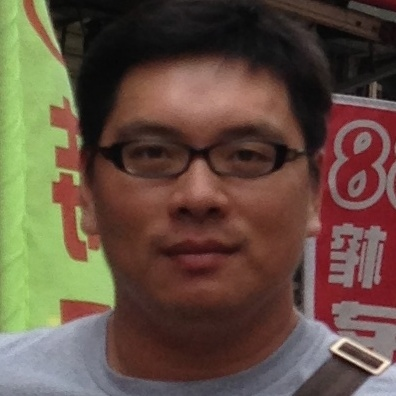

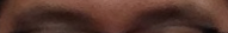

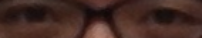

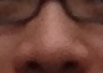

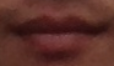

In [ ]:
img=cv2.imread(path)
cv2_imshow(img)
cv2_imshow(eyebrows_img)
cv2_imshow(eyes_img)
cv2_imshow(nose_img)
cv2_imshow(mouth_img)

# Generating Tarin , Test and Validation Data

In [ ]:
from IPython.display import clear_output

train_eyebrow=[]
train_eye=[]
train_nose=[]
train_mouth=[]

test_eyebrow=[]
test_eye=[]
test_nose=[]
test_mouth=[]

val_eyebrow=[]
val_eye=[]
val_nose=[]
val_mouth=[]


i=0
for row in X_train.iterrows():
    #print(row[1].img_path)
    i=i+1
    clear_output(wait=True)
    print("Train image feature extration :", i)
    shape,dets,image=Dlib(row[1].img_path)
    eyebrows_img,eyes_img,nose_img,mouth_img=face_feature(shape,dets,image)
    
    #eyebrow=np.asarray([eyebrows_img])
    train_eyebrow.append(eyebrows_img)
    
    #eye=np.asarray([eyes_img])
    train_eye.append(eyes_img)

    #nose=np.asarray([nose_img])
    train_nose.append(nose_img)

    #mouth=np.asarray([mouth_img])
    train_mouth.append(mouth_img)





In [ ]:

train_eyebrow = np.asarray(train_eyebrow)
train_eye=np.asarray(train_eye)
train_nose=np.asarray(train_nose)
train_mouth=np.asarray(train_mouth)
print('Train images shape {}'.format(len(train_eyebrow)))

Train images shape 2996


In [ ]:
print('Train images shape {}'.format(train_eyebrow.shape))

Train images shape (2996, 33, 228, 3)


In [ ]:
i=0
for row in X_test.iterrows():
    #print(row[1].img_path)
    i=i+1
    
    clear_output(wait=True)
    print("Test Images feature extration : ",i, " off ",len(X_test))
    shape,dets,image=Dlib(row[1].img_path)
    eyebrows_img,eyes_img,nose_img,mouth_img=face_feature(shape,dets,image)


    #eyebrow=np.asarray([eyebrows_img])
    test_eyebrow.append(eyebrows_img)

    #eye=np.asarray([eyes_img])
    test_eye.append(eyes_img)

    #nose=np.asarray([nose_img])
    test_nose.append(nose_img)

    #mouth=np.asarray([mouth_img])
    test_mouth.append(mouth_img)

test_eyebrow = np.asarray(test_eyebrow)
test_eye=np.asarray(test_eye)
test_nose=np.asarray(test_nose)
test_mouth=np.asarray(test_mouth)

print('Test images shape {}'.format(test_eyebrow.shape))


Test Images feature extration :  400  off  400
Test images shape (400, 33, 228, 3)


In [ ]:
print('Test images shape {}'.format(test_eyebrow.shape))

Test images shape (400, 33, 228, 3)


In [ ]:
i=0
for row in x_val.iterrows():
    #print(row[1].img_path)
    i=i+1
    clear_output(wait=True)
    print("Validation image feature extration :",i," off ",len(x_val))
    shape,dets,image=Dlib(row[1].img_path)
    eyebrows_img,eyes_img,nose_img,mouth_img=face_feature(shape,dets,image)


    #eyebrow=np.asarray([eyebrows_img])
    val_eyebrow.append(eyebrows_img)

    #eye=np.asarray([eyes_img])
    val_eye.append(eyes_img)

    #nose=np.asarray([nose_img])
    val_nose.append(nose_img)

    #mouth=np.asarray([mouth_img])
    val_mouth.append(mouth_img)
  

  
val_eyebrow=np.asarray(val_eyebrow)
val_eye=np.asarray(val_eye)
val_nose=np.asarray(val_nose)
val_mouth=np.asarray(val_mouth)
print('Validation images shape {}'.format(val_eyebrow.shape))

Validation image feature extration : 599  off  599
Validation images shape (599, 33, 228, 3)


In [ ]:
print('Validation images shape {}'.format(val_eyebrow.shape))

Validation images shape (599, 33, 228, 3)


#Multi-stream CNN Model


In [ ]:
import keras
from keras.constraints import MaxNorm
from keras.initializers import variance_scaling
from keras.models import Model
from keras.regularizers import  l2,l1
from keras.layers.convolutional import Conv2D
from keras.layers import Dense,Input
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten,Activation,concatenate,BatchNormalization,Dropout
from keras.activations import relu,sigmoid

## CNN stream for eyebrow

In [ ]:
# Eyebrow shape
input_shape=eyebrows_img.shape
filters=32
kernel_size=(3,3)
EyeBrows_Input = Input(shape=input_shape,name="EyeBrows_Input") 
eyebrow = Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True, kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(EyeBrows_Input)
eyebrow = MaxPooling2D(pool_size=(2, 2))(eyebrow)
 
eyebrow =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True, kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(eyebrow)
eyebrow = MaxPooling2D(pool_size=(2, 2))(eyebrow)
eyebrow =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True,  kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(eyebrow)

eyebrow = MaxPooling2D(pool_size=(2, 2))(eyebrow)
eyebrow=Flatten()(eyebrow)

eyebrow = Dense(256,activation="relu")(eyebrow)
eyebrow = Dropout(0.4)(eyebrow)

eyebrow = Dense(256,activation="sigmoid")(eyebrow)

##CNN stream forr eye

In [ ]:
# Eye shape
input_shape=eyes_img.shape
filters=32
kernel_size=(3,3)
Eye_Input = Input(shape=input_shape,name="Eye_Input") 
eye = Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True, kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(Eye_Input)
eye = MaxPooling2D(pool_size=(2, 2))(eye)
 
eye =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True,  kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(eye)
eye = MaxPooling2D(pool_size=(2, 2))(eye)
eye =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True,  kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(eye)

eye = MaxPooling2D(pool_size=(2, 2))(eye)
eye=Flatten()(eye)

eye = Dense(256,activation="relu")(eye)
eye = Dropout(0.4)(eye)

eye = Dense(256,activation="sigmoid")(eye)

##CNN stream for nose

In [ ]:
# Nose shape
input_shape=nose_img.shape
filters=32
kernel_size=(3,3)
Nose_Input = Input(shape=input_shape,name="Nose_Input") 
nose = Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True,  kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(Nose_Input)
nose = MaxPooling2D(pool_size=(2, 2))(nose)
 
nose =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True,  kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(nose)
nose = MaxPooling2D(pool_size=(2, 2))(nose)
nose =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True,  kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(nose)

nose = MaxPooling2D(pool_size=(2, 2))(nose)
nose=Flatten()(nose)

nose = Dense(256,activation="relu")(nose)
nose = Dropout(0.4)(nose)

nose = Dense(256,activation="sigmoid")(nose)

##CNN stream for mouth

In [ ]:
# Mouth shape
input_shape=mouth_img.shape
filters=32
kernel_size=(3,3)
Mouth_Input = Input(shape=input_shape,name="Mouth_Input") 
mouth= Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True,  kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(Mouth_Input)
mouth = MaxPooling2D(pool_size=(2, 2))(mouth)
 
mouth =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True, kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(mouth)
mouth = MaxPooling2D(pool_size=(2, 2))(mouth)
mouth =Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation="relu", 
                                   use_bias=True, kernel_initializer=variance_scaling, bias_initializer=variance_scaling, kernel_regularizer=l2(0.0001), 
                                   bias_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(mouth)

mouth = MaxPooling2D(pool_size=(2, 2))(mouth)
mouth=Flatten()(mouth)

mouth = Dense(256,activation="relu")(mouth)
mouth = Dropout(0.4)(mouth)

mouth = Dense(256,activation="sigmoid")(mouth)

##Concadatenate All CNN stream's

In [ ]:
x=concatenate([eyebrow, eye, nose, mouth], axis = 1)
x = Dense(256,activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(256,activation="relu")(x)
x = Dense(256,activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(8)(x)
model=Model(inputs=[EyeBrows_Input,Eye_Input,Nose_Input,Mouth_Input],outputs=x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EyeBrows_Input (InputLayer)     [(None, 33, 228, 3)] 0                                            
__________________________________________________________________________________________________
Eye_Input (InputLayer)          [(None, 38, 202, 3)] 0                                            
__________________________________________________________________________________________________
Nose_Input (InputLayer)         [(None, 73, 103, 3)] 0                                            
__________________________________________________________________________________________________
Mouth_Input (InputLayer)        [(None, 66, 114, 3)] 0                                            
______________________________________________________________________________________________

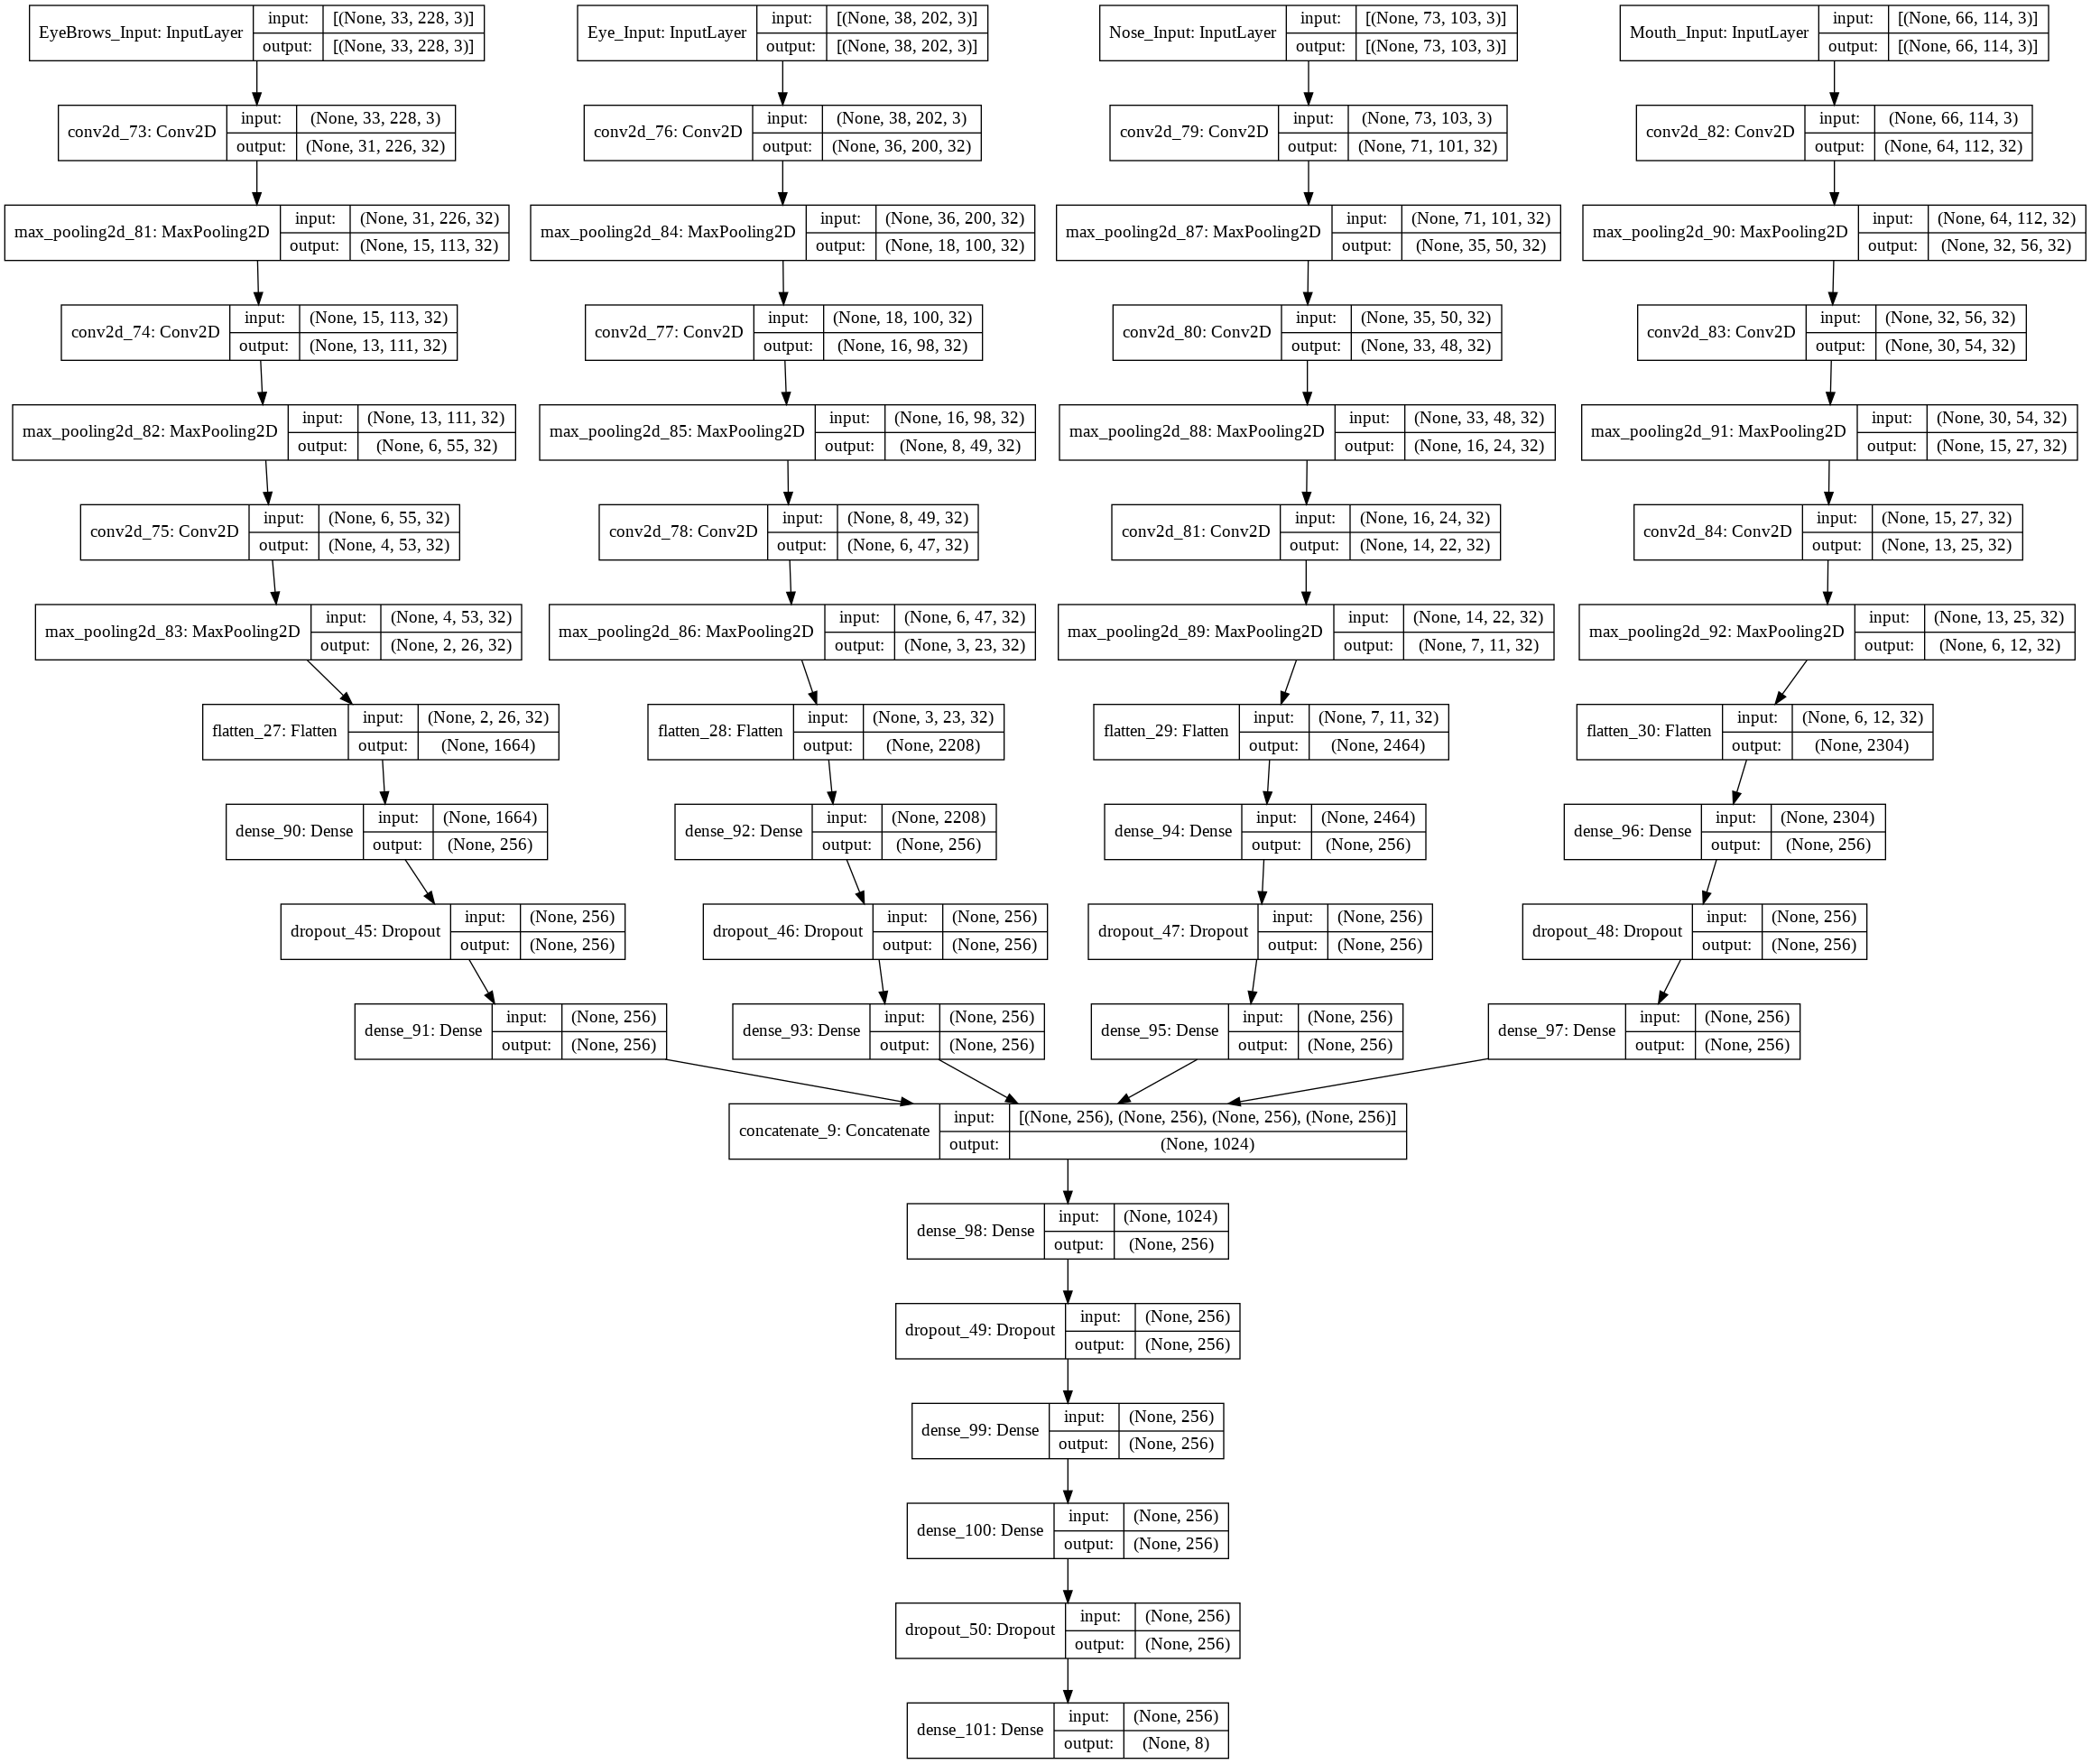

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy ", optimizer=opt,metrics="acc")

In [ ]:
print("[INFO] training model...")
History=model2.fit(x=[train_eyebrow,train_eye,train_nose,train_mouth], y=y_train,epochs=20,validation_data = ([val_eyebrow,val_eye,val_nose,val_mouth], y_val),
                  batch_size=32)

[INFO] training model...
Epoch 1/20
94/94 [==============================] - 104s 1s/step - loss: 317142.3352 - acc: 0.1954 - val_loss: 7758.5474 - val_acc: 0.4124
Epoch 2/20
94/94 [==============================] - 100s 1s/step - loss: 4242.0079 - acc: 0.4011 - val_loss: 1111.9120 - val_acc: 0.4124
Epoch 3/20
94/94 [==============================] - 99s 1s/step - loss: 839.3698 - acc: 0.4003 - val_loss: 631.1371 - val_acc: 0.4124
Epoch 4/20
94/94 [==============================] - 99s 1s/step - loss: 592.1369 - acc: 0.4068 - val_loss: 435.0760 - val_acc: 0.4124
Epoch 5/20
94/94 [==============================] - 99s 1s/step - loss: 388.2345 - acc: 0.4213 - val_loss: 328.7406 - val_acc: 0.4357
Epoch 6/20
94/94 [==============================] - 99s 1s/step - loss: 274.1414 - acc: 0.4335 - val_loss: 257.2299 - val_acc: 0.4891
Epoch 7/20
94/94 [==============================] - 99s 1s/step - loss: 199.5488 - acc: 0.4535 - val_loss: 208.3690 - val_acc: 0.5175
Epoch 8/20
94/94 [===========

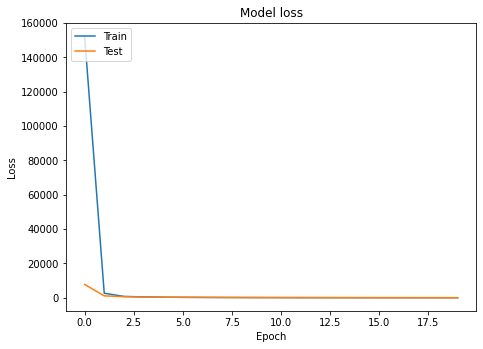

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

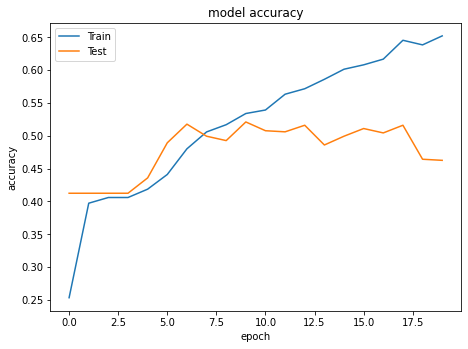

In [ ]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train',"Test"], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
plt.show()

In [ ]:
model.evaluate(x=[test_eyebrow,test_eye,test_nose,test_mouth], y=[y_test], verbose=1)

13/13 [==============================] - 3s 260ms/step - loss: 22.4026 - acc: 0.5275


[22.402587890625, 0.5274999737739563]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = model.predict(x=[test_eyebrow,test_eye,test_nose,test_mouth])
y_pred = np.argmax(Y_pred, axis=1)
target_names = ["0-2", "4-6", "8-13", "15-20" ,"25-32", "38-43", "48-53", "60-"]
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))



Confusion Matrix
[[ 21   7   0   0  14   2   0   0]
 [  4  19   0   0  17   2   2   0]
 [  1   3   1   2  14   1   2   0]
 [  1   2   0   5   7   0   1   0]
 [  6  12   0   1 146   8   8   0]
 [  2   5   1   0  26  13   3   0]
 [  0   2   0   0  16   3   6   0]
 [  1   1   0   0  11   0   1   0]]


In [ ]:
print('Classification Report')

print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         0-2       0.58      0.48      0.53        44
         4-6       0.37      0.43      0.40        44
        8-13       0.50      0.04      0.08        24
       15-20       0.62      0.31      0.42        16
       25-32       0.58      0.81      0.68       181
       38-43       0.45      0.26      0.33        50
       48-53       0.26      0.22      0.24        27
         60-       0.00      0.00      0.00        14

    accuracy                           0.53       400
   macro avg       0.42      0.32      0.33       400
weighted avg       0.50      0.53      0.49       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
